In [1]:
import numpy as np
from scipy.stats import binom_test
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from functools import partial
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor


C:\open_source\anaconda\envs\dev36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Define the XGBoost Quantile Regression Class

In [2]:
class XGBoostQuantile(BaseEstimator, RegressorMixin):
    def __init__(self, quant_alpha,quant_delta,quant_thres,quant_var,
                n_estimators = 100, max_depth = 3,reg_alpha = 0.,reg_lambda=1.0,gamma=0.5):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
        #xgboost parameters
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.reg_alpha= reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        #keep xgboost estimator in memory
        self.clf = None

    def fit(self, X, y):
        def quantile_loss(y_true, y_pred,_alpha,_delta,_threshold,_var):
            x = y_true - y_pred
            grad = (x<(_alpha-1.0)*_delta)*(1.0-_alpha)- ((x>=(_alpha-1.0)*_delta)&
                                    (x<_alpha*_delta) )*x/_delta-_alpha*(x>_alpha*_delta)
            hess = ((x>=(_alpha-1.0)*_delta)& (x<_alpha*_delta) )/_delta
            _len = np.array([y_true]).size
            var = (2*np.random.randint(2, size=_len)-1.0)*_var
            grad = (np.abs(x)<_threshold )*grad - (np.abs(x)>=_threshold )*var
            hess = (np.abs(x)<_threshold )*hess + (np.abs(x)>=_threshold )
            return grad, hess
        
        self.clf = XGBRegressor(
                        objective=partial(quantile_loss,
                        _alpha = self.quant_alpha,
                        _delta = self.quant_delta,
                        _threshold = self.quant_thres,
                        _var = self.quant_var),
                        n_estimators = self.n_estimators,
                        max_depth = self.max_depth,
                        reg_alpha =self.reg_alpha,
                        reg_lambda = self.reg_lambda,
                        gamma = self.gamma)
        self.clf.fit(X,y)
        return self

    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred

    def score(self, X, y):
        y_pred = self.clf.predict(X)
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred)
        score = 1./np.sum(score)
        return score

## Create the Sample Data Set for Testing the Program

In [3]:
np.random.seed(1)
def f(x):
    """The function to predict."""
    return x *np.sin(x)

#----------------------------------------------------------------------
# First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [4]:
X.shape, y.shape

((100, 1), (100,))

## XGBoost Quantile Regression for 5%~95% Confidence Interval

In [5]:
param = {'max_depth':5, 'eta':0.1, 'silent':0, 'objective':'reg:linear', 'alpha': 6.0, 'lambda': 1}
num_round = 1000

dtrain = xgb.DMatrix(data = X, label=y, missing=np.nan)
print ('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'rmse'}, seed = 123,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True, period=20),
                 xgb.callback.early_stop(stopping_rounds=20)])

running cross validation
[0]	train-rmse:3.69301+0.200583	test-rmse:3.66001+0.80391
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[20]	train-rmse:1.85737+0.108385	test-rmse:2.43794+0.699351
[40]	train-rmse:1.66924+0.107901	test-rmse:2.34586+0.672322
[60]	train-rmse:1.63627+0.106865	test-rmse:2.33615+0.662985
[80]	train-rmse:1.6287+0.10658	test-rmse:2.33437+0.659802
[100]	train-rmse:1.62791+0.106875	test-rmse:2.33393+0.658836
[120]	train-rmse:1.62782+0.107012	test-rmse:2.33385+0.658723
Stopping. Best iteration:
[114]	train-rmse:1.62782+0.107012	test-rmse:2.33385+0.658723



,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,3.660008,0.803910,3.693013,0.200583
1,3.478112,0.793196,3.464432,0.185789
2,3.325759,0.775237,3.263025,0.172140
3,3.191432,0.764889,3.085158,0.162240
4,3.084731,0.757169,2.926537,0.154019
5,2.988704,0.739474,2.787567,0.146634
6,2.903784,0.737098,2.660926,0.139714
7,2.829094,0.724908,2.551945,0.134019
8,2.770670,0.722198,2.451483,0.128832
9,2.712453,0.712214,2.364730,0.124989


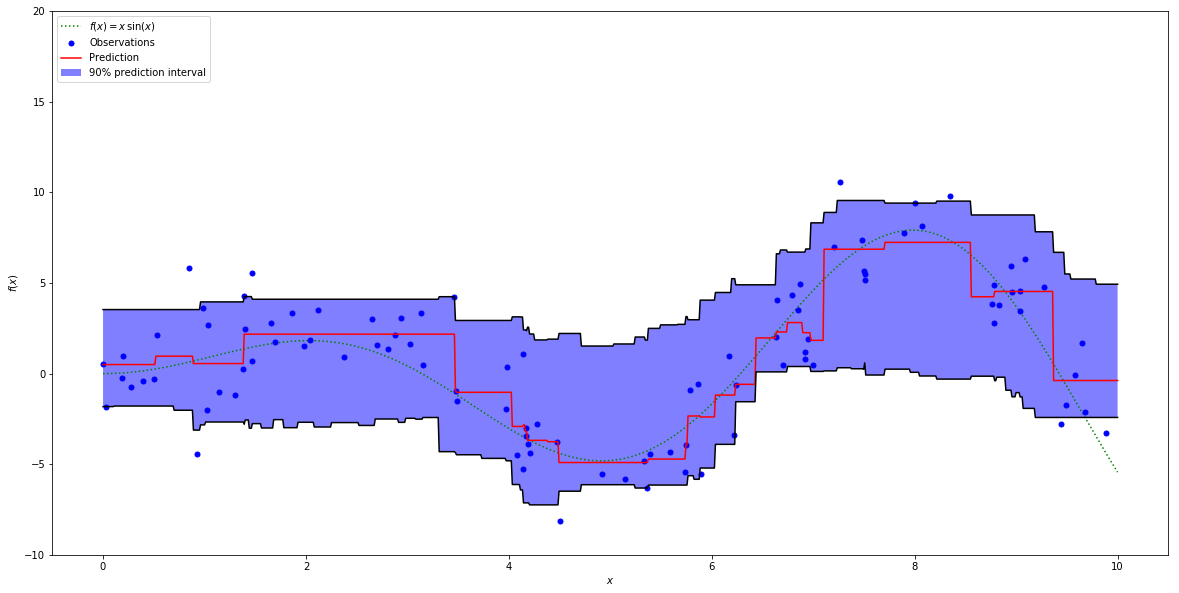

In [6]:
clf = XGBoostQuantile(quant_alpha = 0.05, quant_delta = 0.01,quant_thres = 5.0,quant_var = 2.,
                    n_estimators = 114, max_depth = 5, reg_alpha = 6.,reg_lambda=1.0)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf = XGBoostQuantile(quant_alpha = 0.95, quant_delta = 0.01,quant_thres = 6.0,quant_var = 2.,
                    n_estimators = 114, max_depth = 5, reg_alpha = 6.,reg_lambda=1.0)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
clf = XGBRegressor(n_estimators = 114, max_depth = 5, objective = 'reg:linear',
                   reg_alpha = 6., reg_lambda =1.0, learning_rate=0.1)
clf.fit(X, y)
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure(figsize=(20, 10))
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

## GBM Quantile Regression for 5%~95% Confidence Interval

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf = GradientBoostingRegressor(loss='ls',
                                n_estimators=300, max_depth=2,
                                learning_rate=.01)

scores = cross_val_score(clf, X, y, cv=10)
predicted = cross_val_predict(clf, X, y, cv=10)

print(scores)
np.sqrt(np.mean((predicted - y)**2.))

[ 0.44957888  0.85314317  0.4777609   0.77669495  0.81909907  0.6296285
  0.28576292  0.39645715  0.61852919  0.25673973]


2.2864738181806863

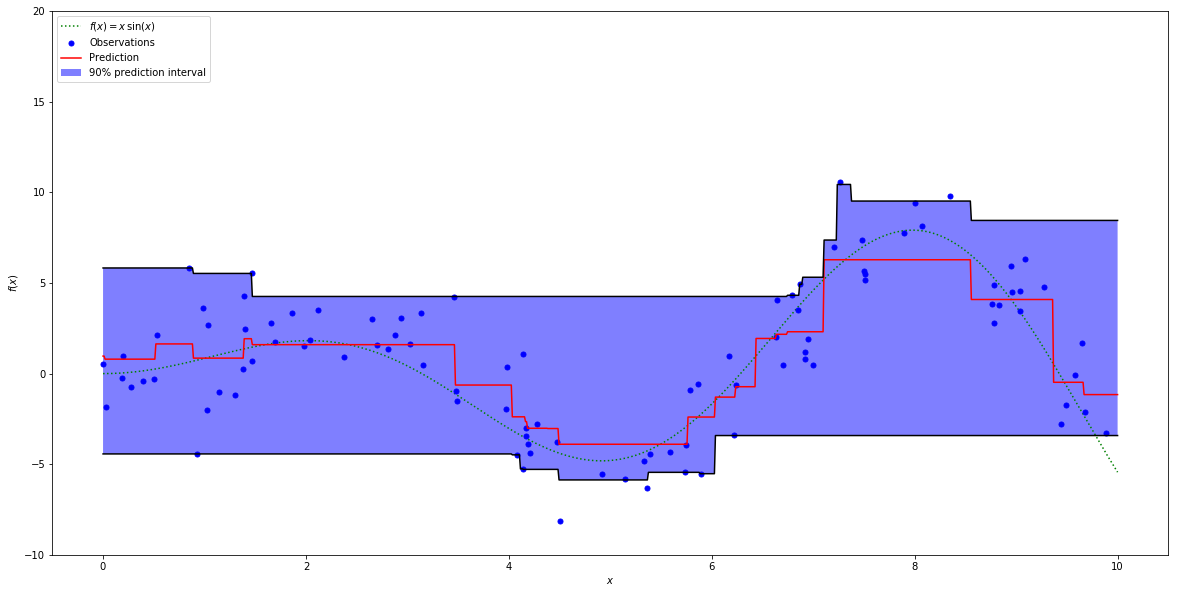

In [8]:
alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=300, max_depth=2,
                                learning_rate=.01)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure(figsize=(20, 10))
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()